In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
import imageio
import random
import time
from itertools import permutations
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from sklearn.cluster import AgglomerativeClustering
from IPython.display import clear_output
import seaborn as sns; sns.set()
from scipy.stats import entropy
#from sklearn import metrics
#from sklearn.datasets.samples_generator import make_blobs
#from sklearn.preprocessing import StandardScaler
#from skimage import img_as_ubyte
from faker import Faker

In [2]:
def sig_func(x,y):
    
    """Example function with PEP 484 type annotations.

    Args:
        x: The first parameter.
        y: The second parameter.

    Returns:
        The return value.
        
    """
    
    return(1/(1+np.exp(-(np.dot(x,y)))))

In [3]:
def colorize(cell_weights, color_mode):
    
    """Example function with PEP 484 type annotations.

    Args:
        x: The first parameter.
        y: The second parameter.

    Returns:
        The return value.
        
    """
    
    # Handle color modes for animation.
    if(color_mode == 0):    
        cell_color = np.add(1, AgglomerativeClustering(7).fit(cell_weights).labels_)/8
    else: 
        try:
            p = (np.transpose(PCA(n_components=3).fit(np.transpose(cell_weights)).components_)+1)/2
            rgb = np.round(255*(p-np.min(p))/(np.max(p)-np.min(p)))/((256^2)*256 + 256*256 + 256)
            if(color_mode == 1):
                cell_color = (256^2)*rgb[:,0] + 256*rgb[:,1] + rgb[:,2]
            if(color_mode == 2):
                cell_color = (256^2)*rgb[:,2] + 256*rgb[:,1] + rgb[:,0]
            if(color_mode == 3):
                cell_color = 256*rgb[:,0] + 256*rgb[:,1] + 256*rgb[:,2]
        except:
            print("Extinction event occured!  Had to return.")
            #return(im,)
    return(cell_color)

In [4]:
def mutate(x,rate):
    
    """Example function with PEP 484 type annotations.

    Args:
        x: The first parameter.
        rate: The second parameter.

    Returns:
        The return value.
        
    """
    
    chosen = np.random.choice(range(0,len(x)),rate,replace=False)
    for i in range(0,len(x)):
        if i in chosen:
            x[i] = 2*np.random.random(1)-1
    return(x)

In [5]:
def intersection(lst1, lst2):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    
    return list(set(lst1) & set(lst2))

In [6]:
def extract_tribe(cells, cell_weights, fake_names, n, labels, node_n = 225):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    
    db = AgglomerativeClustering(n).fit(cell_weights)
    print(db.labels_)
    flags = []
    for k in labels:
        flags = [flags, [j for j, x in enumerate(db.labels_ == k) if x]]
    flags = flags[1:]
    print(flags)
    next_cells = cells[flags,:]  
    next_weights = cell_weights[flags,:]
    next_fake_names = [fake_names[x] for x in flags]
    print(next_fake_names)
    return(next_cells[0], next_weights[0], next_fake_names[0], db)

In [7]:
def fuzzy_logic(a):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.
        
    """
    
    less_norm = np.linalg.norm([i for i in a if i <= np.median(a)])
    cutoff = np.min(a)/less_norm + np.random.rand()*((np.median(a)-np.min(a))/less_norm)
    choice = a.index(np.random.choice([i for i in a if i <= cutoff*less_norm]))
    
    return(choice)

In [8]:
def slime(x = [],
          y = [],
          z = [],
          start_pop = 200,
          max_age = 100,
          fig_size = [5,5],
          board_size = 128,
          fertile = 6,
          start_hp = 3,
          log = False,
          frames=500,
          interval=50,
          mutation_rate = 1,
          willing_wait = 5,
          experimental = False,
          mode='once'):
    
    """Example function with PEP 484 type annotations.

    Args:
        lst1: The first parameter.
        lst2: The second parameter.

    Returns:
        The return value.

    """
    
    global sight
    global time_tick
    global heal_count
    global birth_count
    global bump_count
    global trends
    global cells
    global cell_weights
    global baby_name
    global border
    global last_time
    global new_coord
    global G
    global for_gif
    global max_hp
    global frame_count
    global fake
    global fake_names
    
    images = []
    fake = Faker()    
    total_start_time = time.time()
    frame_count = 1
    max_hp = fertile
    sight = 9
    G = nx.Graph()
    time_tick = 0
    trends = np.array([0,0,0,0,0,0,0])
    border = round(board_size/3)
    last_time = 0
    baby_name = 1
    fake_names = fake.name()
    new_coord = [[-1,1],
                 [0,1],
                 [1,1],
                 [-1,0],
                 [0,0],
                 [1,0],
                 [-1,-1],
                 [0,-1],
                 [1,-1]]
    
    # Get the relative coodinates for the input.
    L = [0, 0, 1, 1, -1, -1, 2, 2, -2, -2, 3, 3, -3, -3, 4, 4, -4, -4]
    sight_keep = [0,0]
    for j in permutations(L, r=2):
        sight_keep = np.vstack((sight_keep, j))
        
    # Create the board.
    X = np.zeros(shape=(board_size,board_size))
    for_gif = X
    
    # Build the initial cell list.  Skip this if one from a previous run is submitted.
    # The NN is built around sight/input of 9*9, movement/output of 3*3.
    if(len(x) < 1):
        cells = np.zeros((start_pop,5))
        cell_weights = np.zeros((start_pop,(sight*sight*3*3)))      
        for i in range(0,start_pop):
            cells[i,:] = [baby_name,
                          np.random.choice(range(border, board_size-border)),
                          np.random.choice(range(border, board_size-border)),
                          start_hp,
                          1]
            cell_weights[i,:] = 2*np.random.random((sight*sight*3*3))-1
            G.add_node(i)
            baby_name += 1
            fake_names = np.append(fake_names,fake.name())          
    else:
        cells = x
        cell_weights = y
        fake_names = z
        baby_name = len(z) + 1
    
    # initialization function: plot the background of each frame
    def init():
        im.set_data(10*X)
        return(im,)
        
    # Setup plotting.
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap='nipy_spectral', interpolation='nearest')
    im.set_clim(0, 8)
        
    def animate(i):
        global sight
        global time_tick
        global heal_count
        global birth_count
        global bump_count
        global trends
        global cells
        global cell_weights
        global baby_name
        global total_pop
        global killed
        global border
        global last_time
        global new_coord
        global G
        global for_gif
        global max_hp
        global frame_count
        global fake
        global fake_names
        
        """Example function with PEP 484 type annotations.

        Args:
            lst1: The first parameter.
            lst2: The second parameter.

        Returns:
            The return value.

        """
        
        # Warning for long frame generation wait time.
        if(last_time > willing_wait):
            print("Taking too long...  Frame {} took {} seconds.".format((frame_count-1),round(last_time,1)))
        
        # Initial values.
        start_time = time.time()
        heal_count = 0
        birth_count = 0
        bump_count = 0
        killed_this_round = np.array([], dtype = int)
        time_tick += 1
        im.set_data(10*animate.X)
        
        # Handle color for animation and input value.
        cell_color = np.add(1, AgglomerativeClustering(7).fit(cell_weights).labels_)/8
    
        # Take turns through the cell list for each frame.
        for i in range(0, len(cells)):
            if(int(cells[i,0] in killed_this_round) == 0):
                # Input.
                test_in = []
                for j in np.mod(cells[i,1:3] + np.unique(sight_keep,axis=0), board_size).astype(int):
                    test_in = np.append(test_in, X[j[0], j[1]])

                # Output.
                test_out = sig_func(test_in,cell_weights[i,:].reshape((sight*sight, 3*3)))
                d = fuzzy_logic(test_out.tolist())

                # Rest and recover up to half fertile health.
                if(d==4):
                    if(cells[i,3] < max_hp/2):
                        cells[i,3] += 1
                        heal_count += 1
                        if(log == True):
                            print("{} rested and raised hp to {}.".format(fake_names[i], cells[i,3]))

                    # Handle birth/splitting, don't clear.
                    if(cells[i,3] >= max_hp):

                        # Get the relative coodinates for possible baby locations.
                        potential = []
                        for j in np.mod(cells[i,1:3] + np.unique(new_coord,axis=0), board_size).astype(int):
                            potential = np.append(potential, X[j[0], j[1]])

                        # Check if location for baby is clear
                        clear = []
                        for j in potential:
                            if(j == 0):
                                clear = np.append(clear,j)

                        # Cell division process, only divide if there is a vacant destination to choose from.
                        if(len(clear) > 0):
                            d = np.random.choice(range(0,len(clear)))
                            # Give new coordinate and fill it in.
                            destination = np.mod(np.add(cells[i,1:3], new_coord[d]), board_size).astype(int)

                            # Half parent hp.
                            divided_hp = np.floor(cells[i,3]/2)
                            cells[i,3] = divided_hp

                            # Give the baby attributes.
                            G.add_node(baby_name)
                            G.add_edge(cells[i,0], baby_name)
                            fake_baby_name = fake.name()
                            fake_names = np.append(fake_names,fake_baby_name)
                            a = [baby_name,
                                 int(destination[0]),
                                 int(destination[1]),
                                 divided_hp,
                                 1]

                            # Mutate the baby's NN
                            b = mutate(cell_weights[i,:], mutation_rate)
                            cells = np.vstack((cells, a)) 
                            cell_weights = np.vstack((cell_weights, b))
                            
                            # Fill in the baby's first cell on the board.  Light it up
                            X[destination[0], destination[1]] = np.max(cell_color)*2
                            
                            baby_name += 1
                            birth_count += 1
                            if(log == True):
                                print("{} underwent mitosis.  Gave birth to {}.".format(fake_names[i], fake_baby_name))

                # Movement logic.
                else:
                    # If it is clear to move.
                    destination = np.mod(np.add(cells[i,1:3], new_coord[d]), board_size).astype(int)

                    if(X[destination[0], destination[1]] == 0):
                        # Clear where it was since it is not splitting.
                        last_spot = cells[i,1:3].astype(int)
                        X[last_spot[0], last_spot[1]] = 0         
                        # Give new coordinate and fill it in.
                        cells[i,1:3] = destination
                        X[destination[0], destination[1]] = cell_color[i]

                    else:
                        # It has an altercation
                        bump_count += 1
                        x = [i for i, j in enumerate(cells[:,1]) if j == destination[0]]
                        y = [i for i, j in enumerate(cells[:,2]) if j == destination[1]]
                        z = intersection(x,y)

                        # Make sure there is no ambiguity
                        if(len(z) == 1):
                            z = z[0]
                            # The outcome is determined by hit points, age and who is initiating.
                            # The following ratio incorperates ages of predator and prey
                            rat = np.log(cells[z,4]/cells[i,4])/np.e

                            # Experimental ################################################
                            if(experimental == True):
                                # Get the relative coodinates
                                potential = []
                                for j in np.mod(cells[i,1:3] + np.unique(new_coord,axis=0), board_size).astype(int):
                                    potential = np.append(potential, X[j[0], j[1]])
                            ###############################################################

                            if(cells[i,3] > cells[z,3]):
                                attacker_hp_before = cells[i,3]
                                defender_hp_before = cells[z,3]
                                cells[i,3] += np.round(3+rat)
                                cells[z,3] -= np.round(3+rat)

                                if(log == True):
                                    print("{} attacked {}!".format(fake_names[i], fake_names[z]))
                                    print("{} hp: {} --> {}".format(fake_names[i], attacker_hp_before, cells[i,3]))
                                    print("{} hp: {} --> {}".format(fake_names[z], defender_hp_before, cells[z,3]))

                                # Experimental ################################################
                                if(experimental == True):
                                    reward = np.array((np.repeat(1,9)))
                                    reward[d] = 0
                                    cell_weights[i,:] += np.dot(potential.T,(test_out-reward)*reward*(1-reward))     
                                ###############################################################

                            if(cells[i,3] == cells[z,3]):
                                attacker_hp_before = cells[i,3]
                                defender_hp_before = cells[z,3]
                                cells[i,3] += np.round(1+rat)
                                cells[z,3] -= np.round(1+rat)

                                if(log == True):
                                    print("{} attacked {}!".format(fake_names[i], fake_names[z]))
                                    print("{} hp: {} --> {}".format(fake_names[i], attacker_hp_before, cells[i,3]))
                                    print("{} hp: {} --> {}".format(fake_names[z], defender_hp_before, cells[z,3]))

                                # Experimental ################################################
                                if(experimental == True):
                                    reward = np.array((np.repeat(1,9)))
                                    reward[d] = 0
                                    cell_weights[i,:] += np.dot(potential.T,(test_out-reward)*reward*(1-reward))
                                ###############################################################

                            if(cells[i,3] < cells[z,3]):
                                attacker_hp_before = cells[i,3]
                                defender_hp_before = cells[z,3]
                                cells[i,3] -= np.round(2-rat)
                                cells[z,3] += np.round(2-rat)

                                if(log == True):
                                    print("{} attacked {}!".format(fake_names[i], fake_names[z]))
                                    print("{} hp: {} --> {}".format(fake_names[i], attacker_hp_before, cells[i,3]))
                                    print("{} hp: {} --> {}".format(fake_names[z], defender_hp_before, cells[z,3]))

                                # Experimental ################################################
                                if(experimental == True):
                                    reward = np.array((np.repeat(0,9)))
                                    reward[d] = 1
                                    cell_weights[i,:] += np.dot(potential.T,(test_out-reward)*reward*(1-reward)) 
                                ###############################################################

                            # Experimental ################################################
                            if(log == True):
                                print("Experimental nurture reenforcement modified {}'s neural network.".format(fake_names[i]))  
                            ###############################################################
                            
                            # Handle cell death.
                            if(cells[i,3] < 1):
                                # Clear where the attacker was and add to the death list.
                                last_spot = cells[i,1:3].astype(int)
                                X[last_spot[0],last_spot[1]] = 0
                                killed_this_round = np.append(killed_this_round,int(cells[i,0]))
                                if(log == True):
                                    print("{} collapsed from injury!.".format(fake_names[i]))

                            if(cells[z,3] < 1):
                                # Clear where the victim was and add to the death list.
                                last_spot = cells[z,1:3].astype(int)
                                X[last_spot[0],last_spot[1]] = 0
                                killed_this_round = np.append(killed_this_round,int(cells[z,0]))
                                if(log == True):
                                    print("{} collapsed from injury!.".format(fake_names[z]))
                                    
        # Kill the elderly        
        for i in range(0, len(cells)):
            if(cells[i,4] > max_age):
                # Blur max age a bit.
                if(np.random.random() < (cells[i,4]-max_age)/max_age):      
                    # Add to the death list.
                    killed_this_round = np.append(killed_this_round,int(cells[i,0]))
                    if(log == True):
                        print("{} collapsed from old age!.".format(fake_names[i]))

        # Finally handle the death list and delete cells
        for i in np.unique(killed_this_round):
            j = list(cells[:,0]).index((i))
            last_spot = cells[j,1:3].astype(int)
            X[last_spot[0],last_spot[1]] = 0
            if(log == True):
                print("{} died at age {}.".format(fake_names[j],cells[j,4]))
            cells = np.delete(cells, (j), axis=0)
            cell_weights = np.delete(cell_weights, (j), axis=0)
            fake_names = np.delete(fake_names, (j))

        # Dynamic population control
        if(np.random.random() < -np.log(len(cells)/(start_pop)/np.e)):
            if(max_hp > 3):
                    max_hp -= 1
                    print("We're going extinct, make babies!  Breeding requirements decreased to {}.".format(max_hp))
        if(np.random.random() < np.log(len(cells)/(start_pop)/np.e)):
                max_hp += 1
                print("Too crowded, stop having kids!  Breeding requirements increased to {}.".format(max_hp))

        # Get mean variance
        mean_var = np.mean(np.var(cell_weights,axis = 0))       
        # Tick everyone's age
        cells[:,4] = np.add(cells[:,4],1)
        # Capture array for gif
        for_gif = np.concatenate((for_gif, X))
        # Capture death statistics
        death_count = len(np.unique(killed_this_round))
        # Current frame summary
        current = np.array([time_tick, heal_count, birth_count, bump_count, death_count, len(cells), mean_var])
        # Append to run summary
        trends = np.vstack((trends, current))
        # Save frame png
        im.figure.savefig("slime.png")
        images.append(imageio.imread('slime.png')) 
        # Get the current frame run time to check next frame
        last_time = time.time() - start_time
        # Log every 10 frames to monitor full run time and check frame generation time.
        if(np.mod(frame_count,10) == 0):
            print("Frame {} took {} seconds.".format(frame_count,round(last_time,1)))        
        frame_count += 1
    
        return(im,)
    
    # Handles the browser animation viewer.
    animate.X = X
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=interval, blit=True)
    html_result = display_animation(anim, default_mode=mode)
    
    # Make an animated gif
    imageio.mimsave('slime.gif', images)
    
    # Total run time
    total_last_time = time.time() - total_start_time
    print("Total Run Time:  {} seconds.".format(round(total_last_time,1)))
    
    return(html_result, cells, cell_weights, fake_names, G, trends[1:,:], for_gif)

In [9]:
gr, c, cw, fn, g, t, a = slime(frames=100, experimental = True, log = False)

We're going extinct, make babies!  Breeding requirements decreased to 5.
We're going extinct, make babies!  Breeding requirements decreased to 4.
We're going extinct, make babies!  Breeding requirements decreased to 3.
Frame 10 took 0.4 seconds.
Frame 20 took 0.4 seconds.
Frame 30 took 0.5 seconds.
Frame 40 took 0.5 seconds.
Frame 50 took 0.5 seconds.
Frame 60 took 0.5 seconds.
Frame 70 took 0.5 seconds.
Frame 80 took 0.4 seconds.
Frame 90 took 0.5 seconds.
Frame 100 took 0.5 seconds.
Total Run Time:  53.0 seconds.



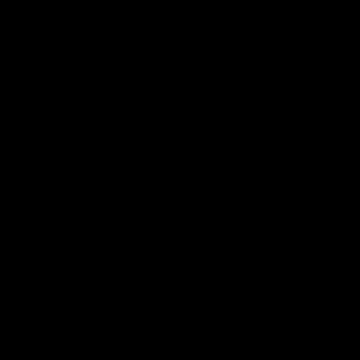
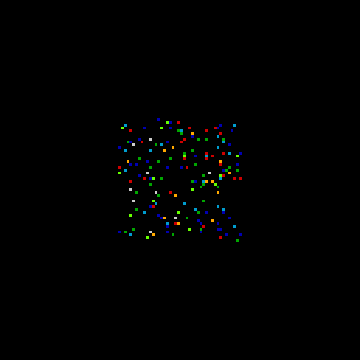
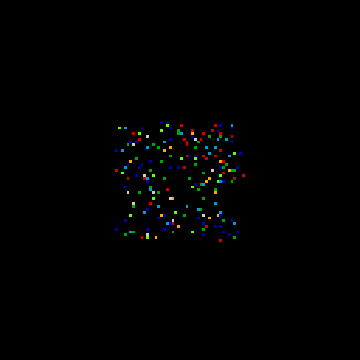
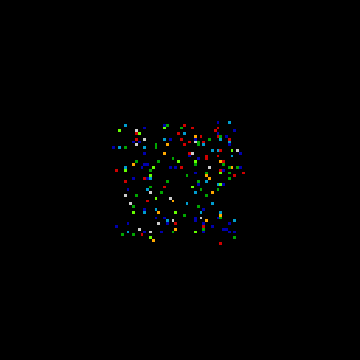
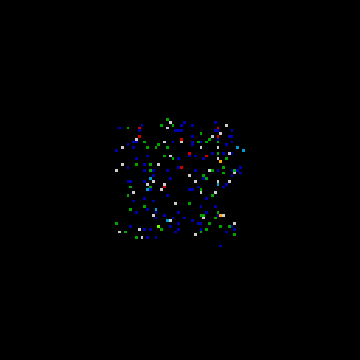
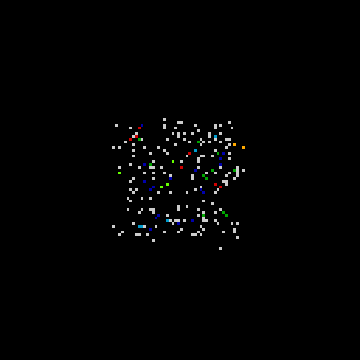
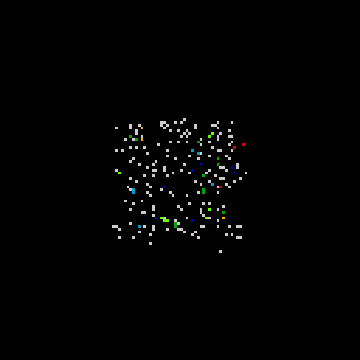
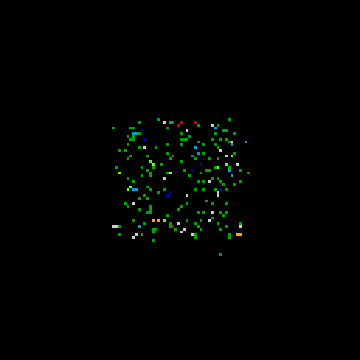
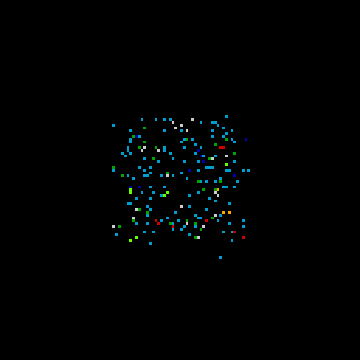
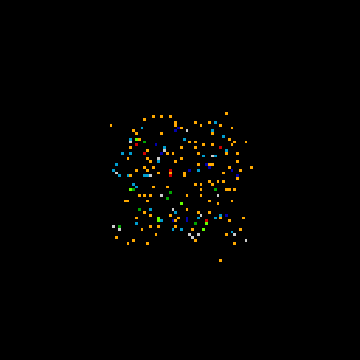
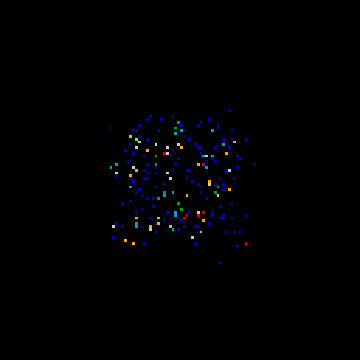
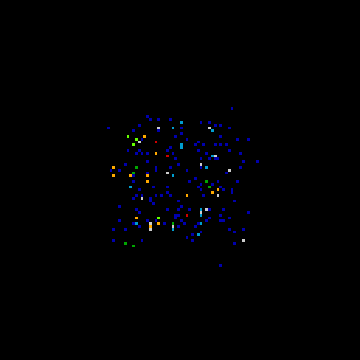
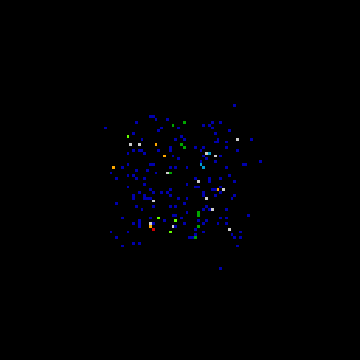
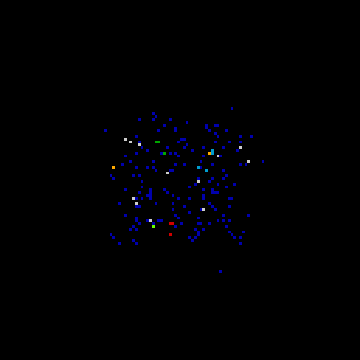
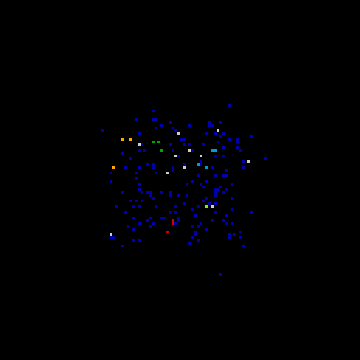
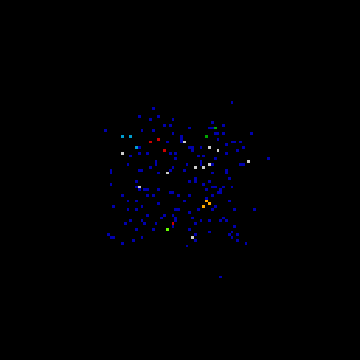
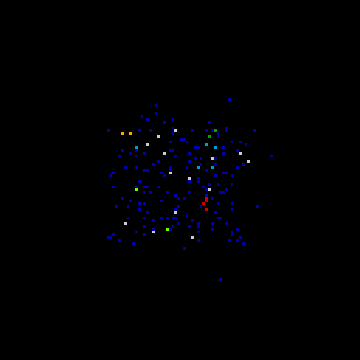
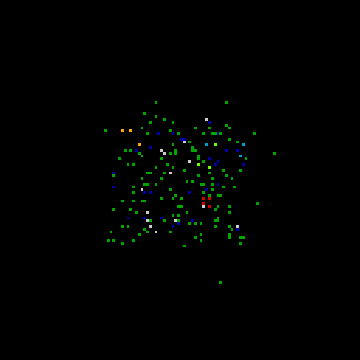
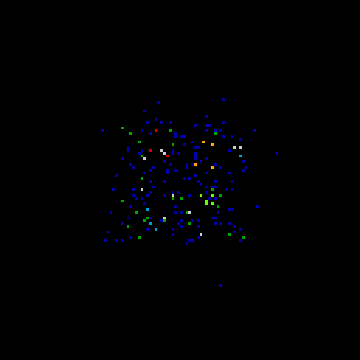
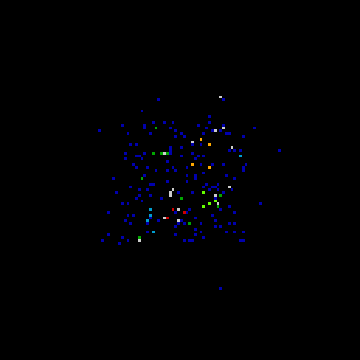
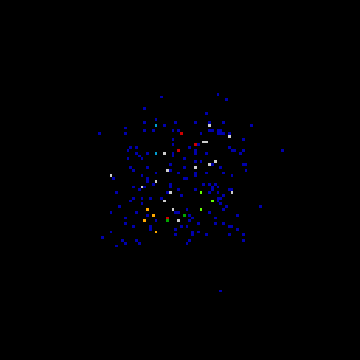
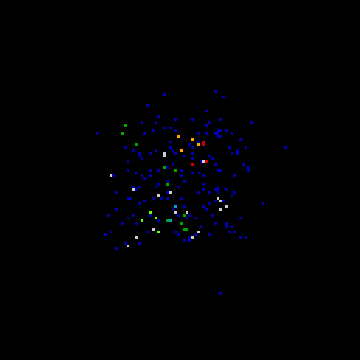
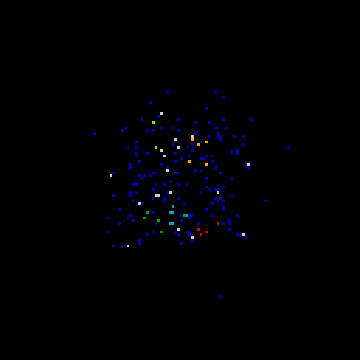
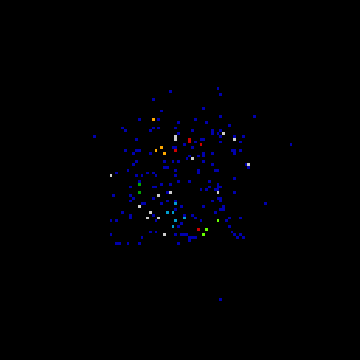
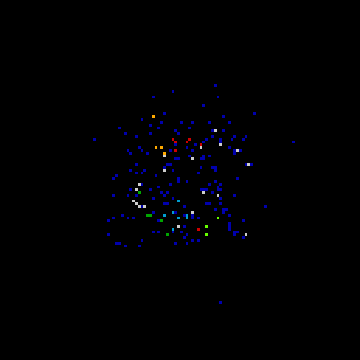
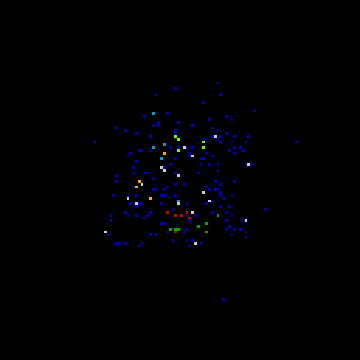
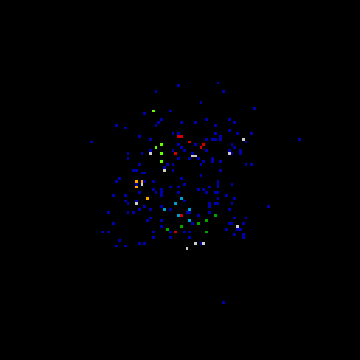
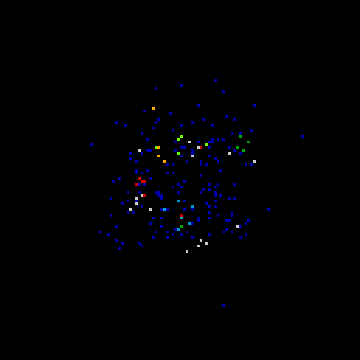
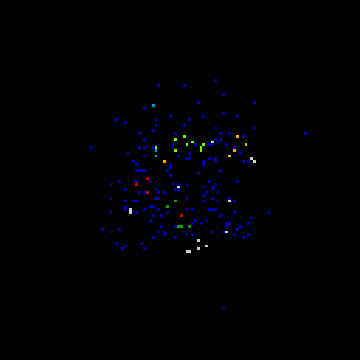
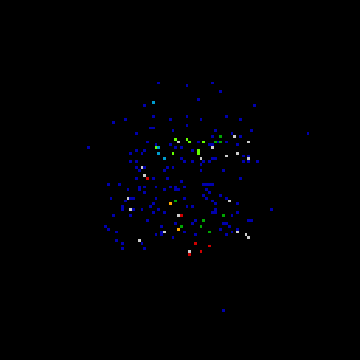
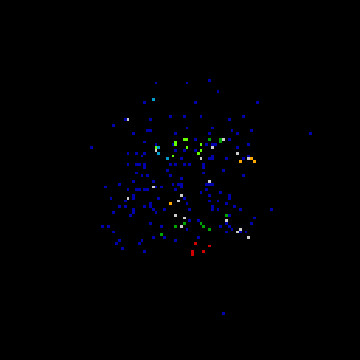
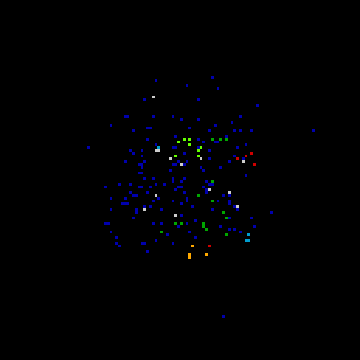
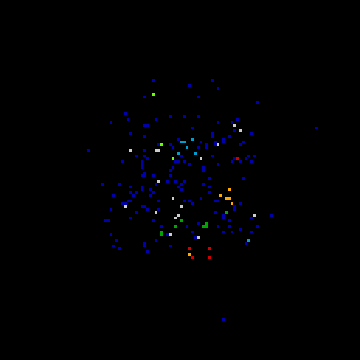
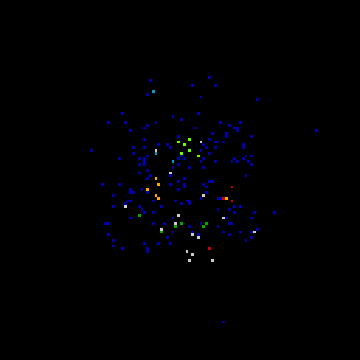
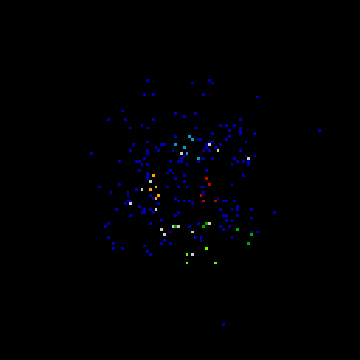
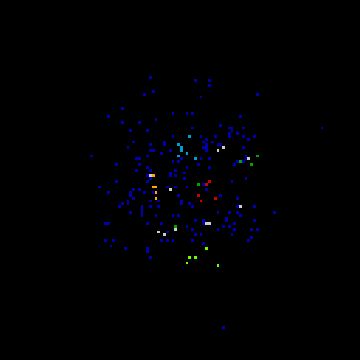
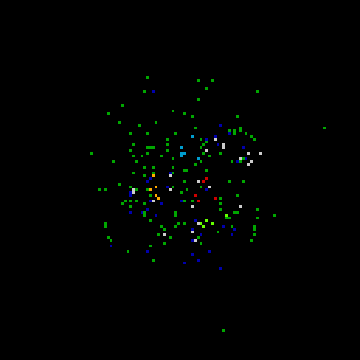
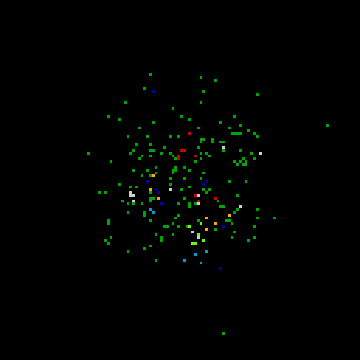
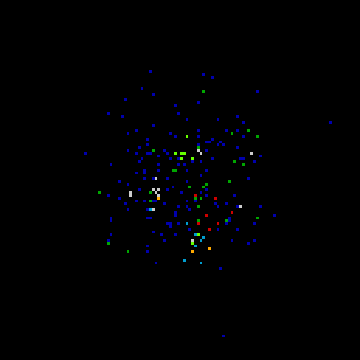
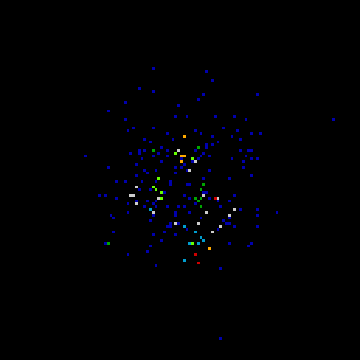
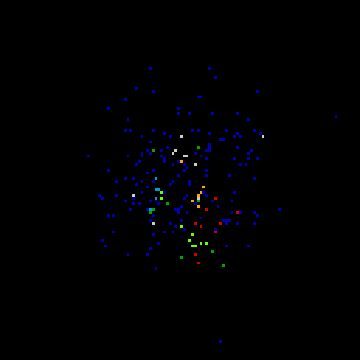
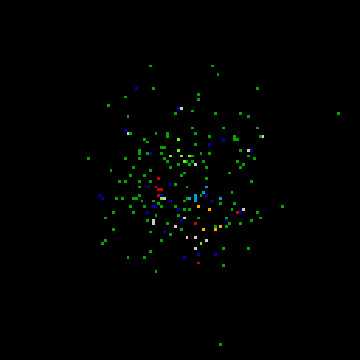
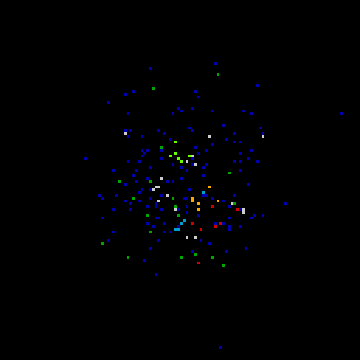
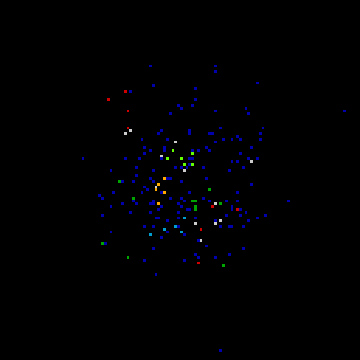
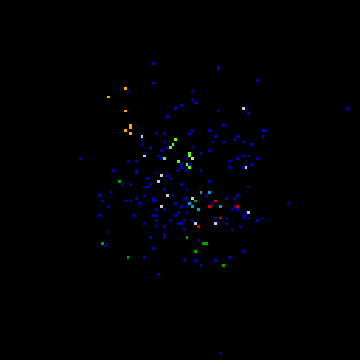
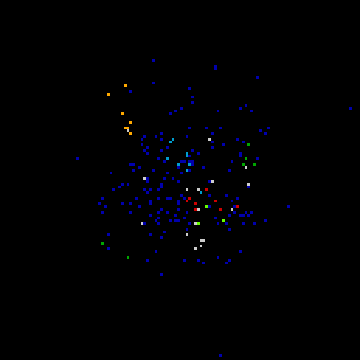
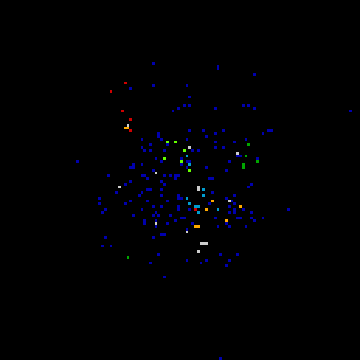
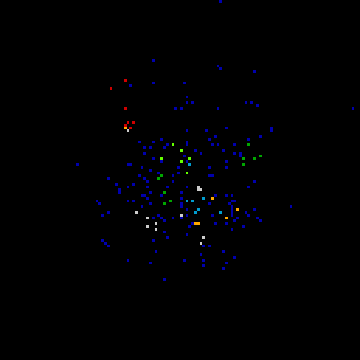
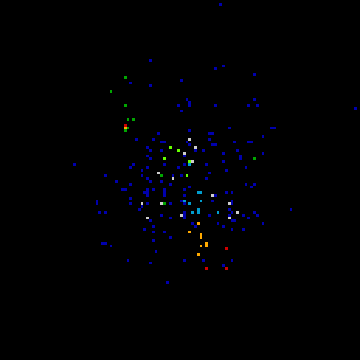
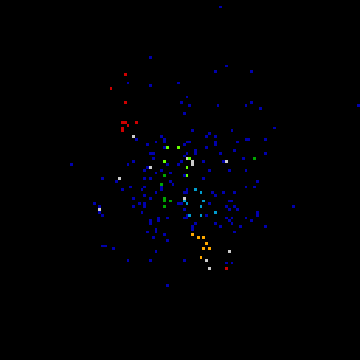
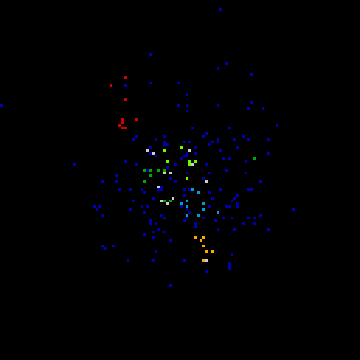
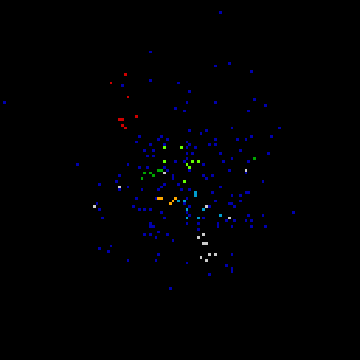
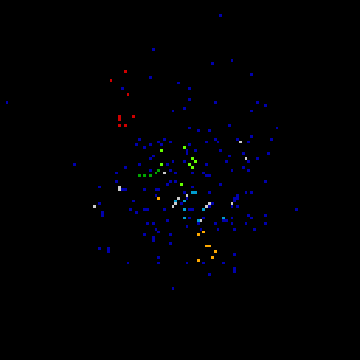
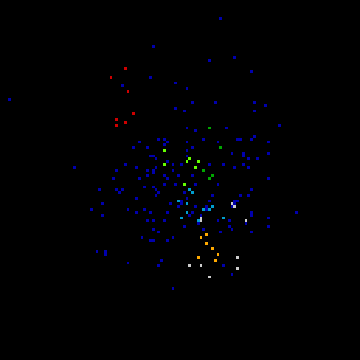
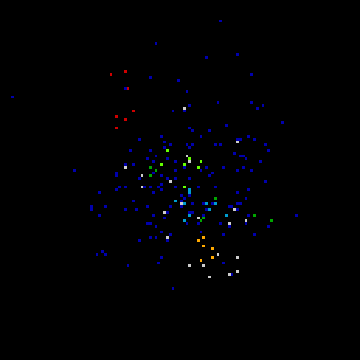
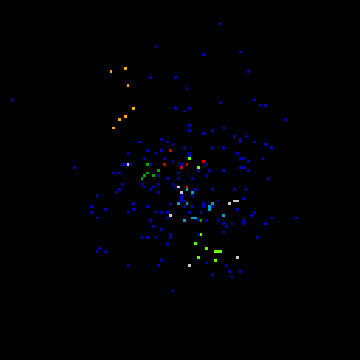
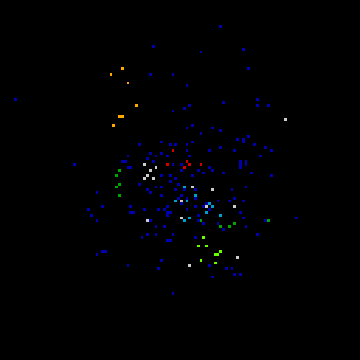
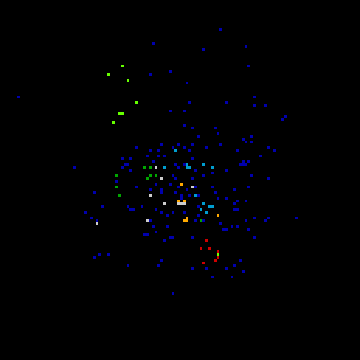
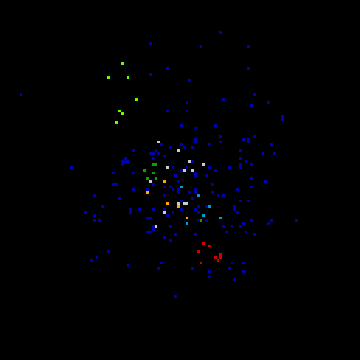
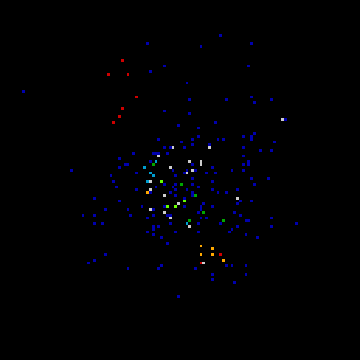
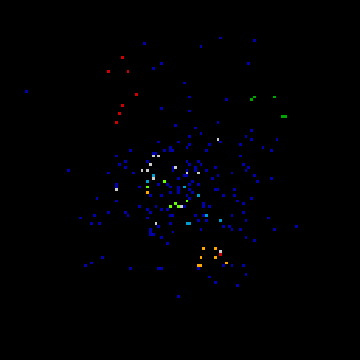
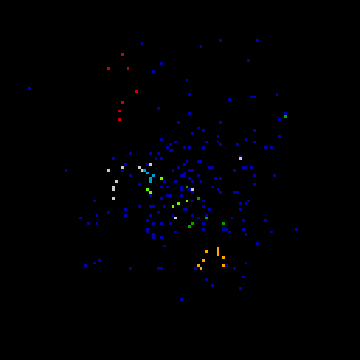
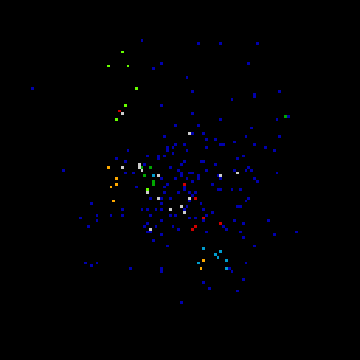
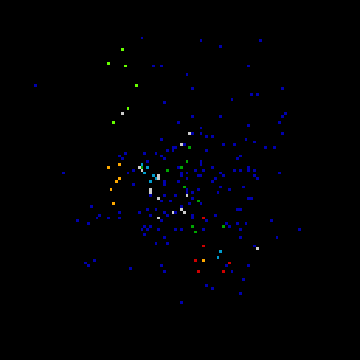
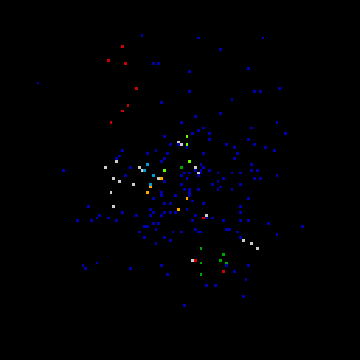
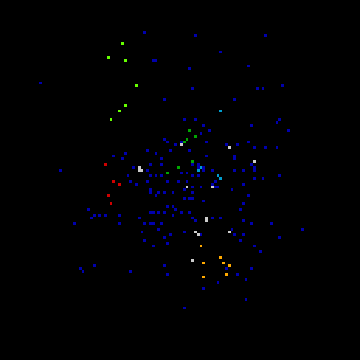
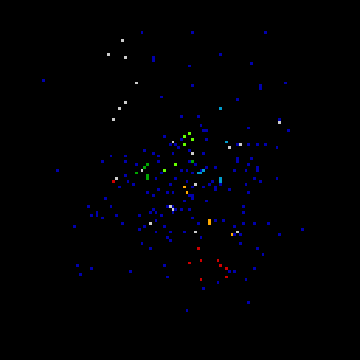
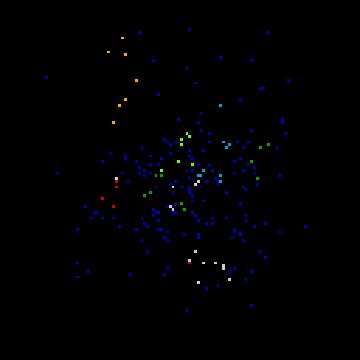
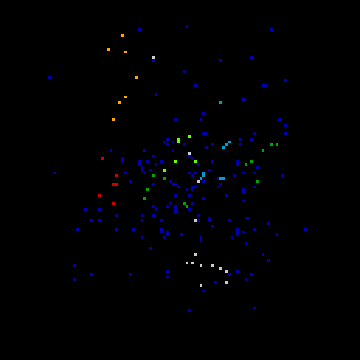
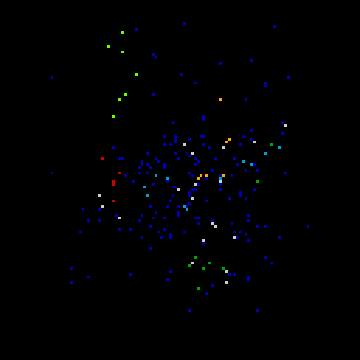
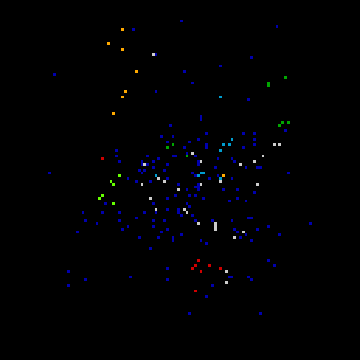
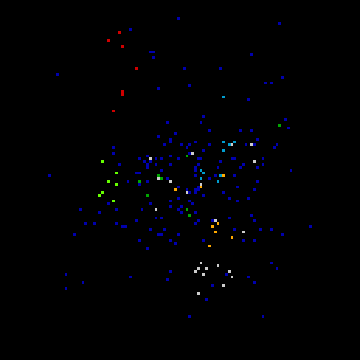
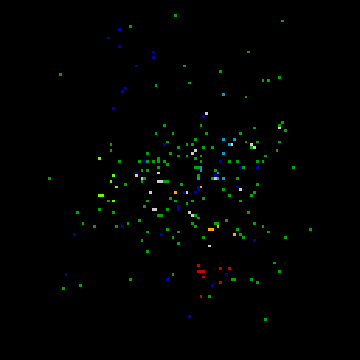
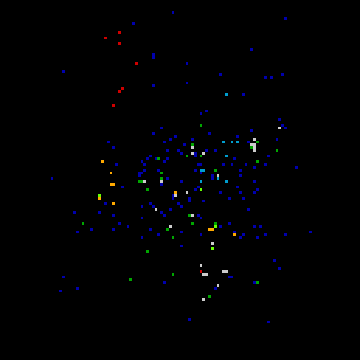
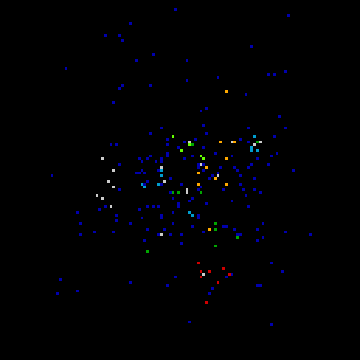
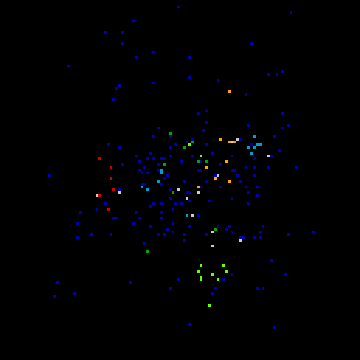
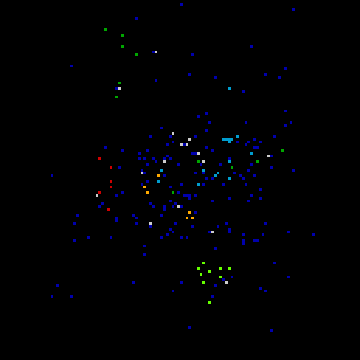
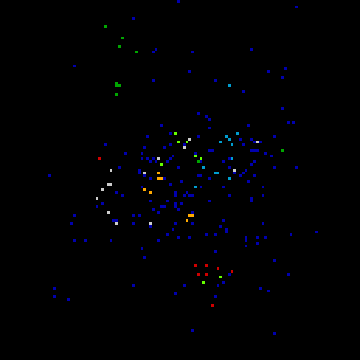
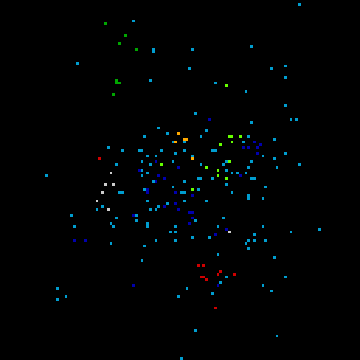
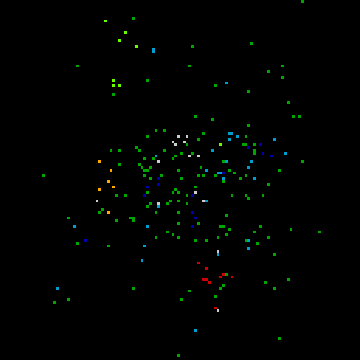
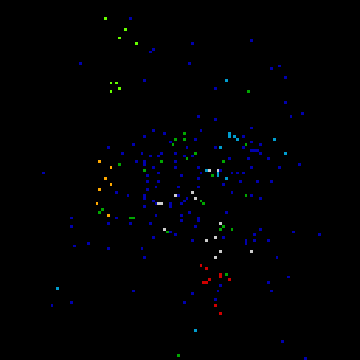
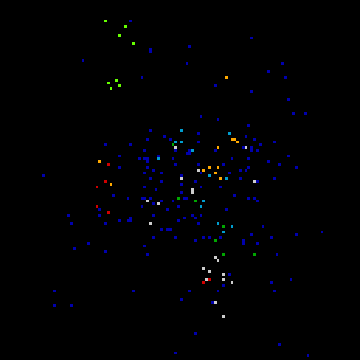
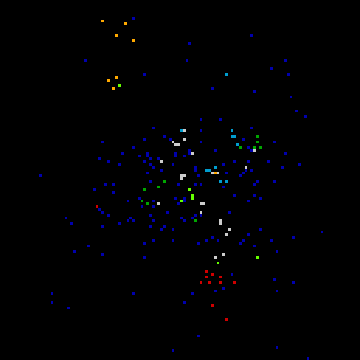
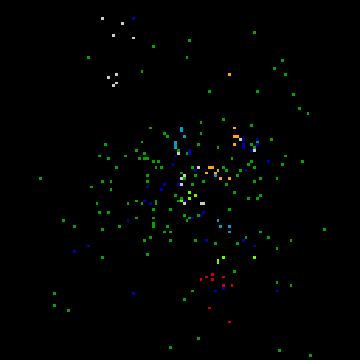
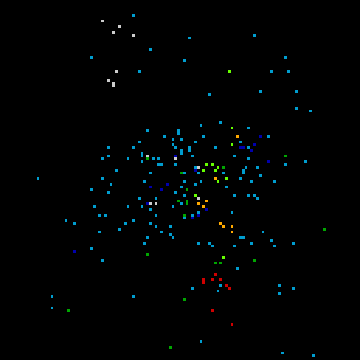
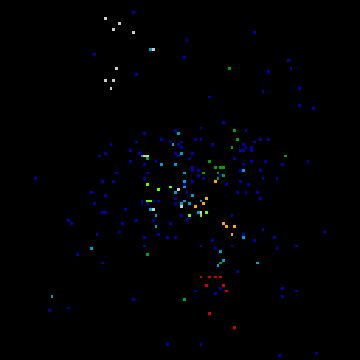
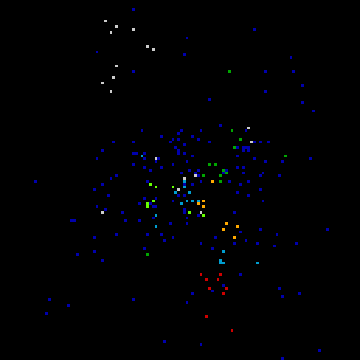
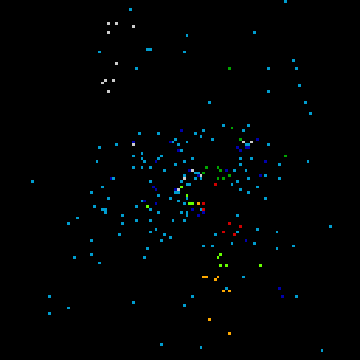
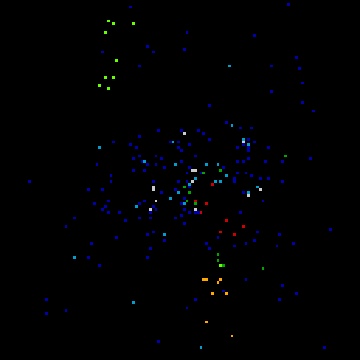
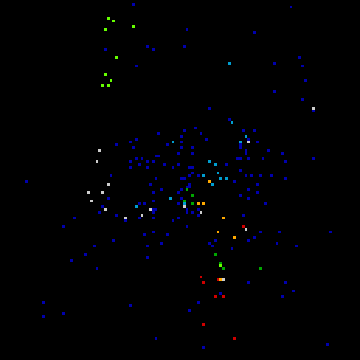
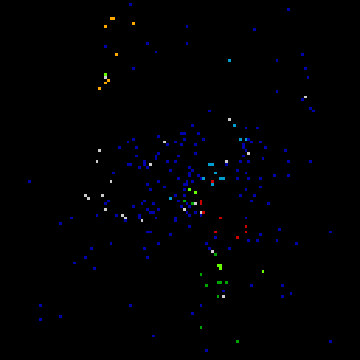
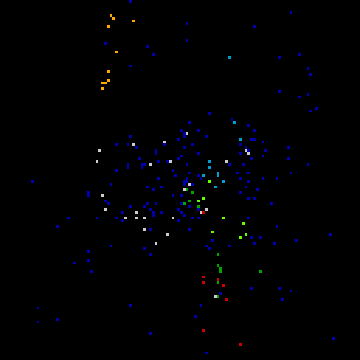
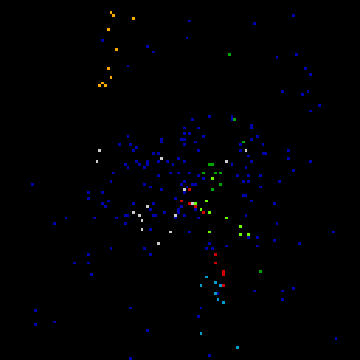
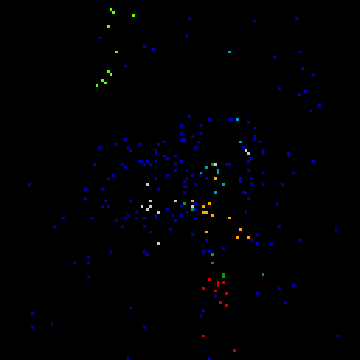
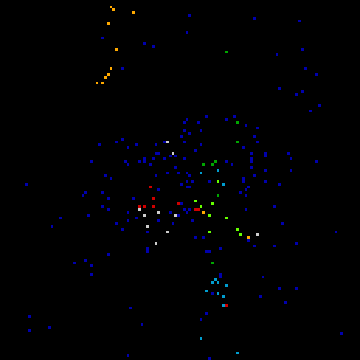
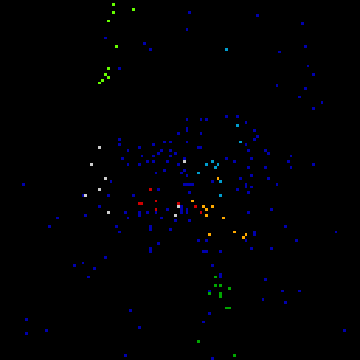
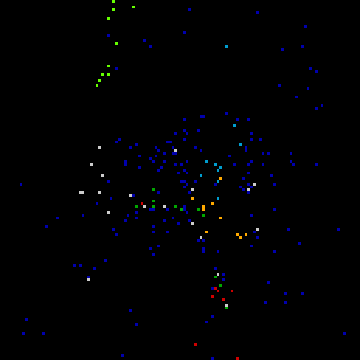
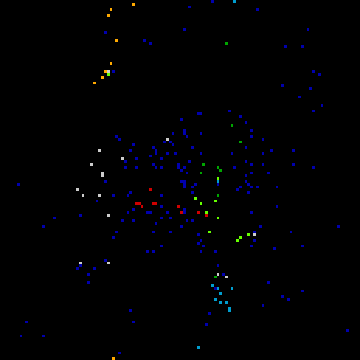
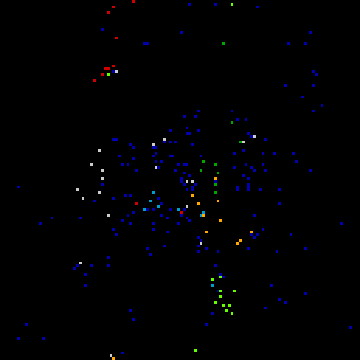
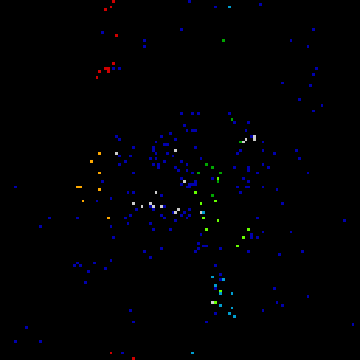

In [10]:
gr

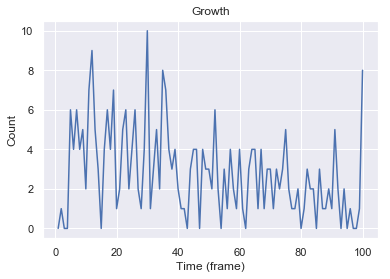

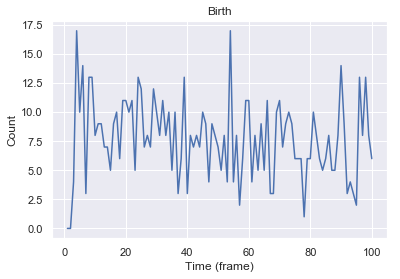

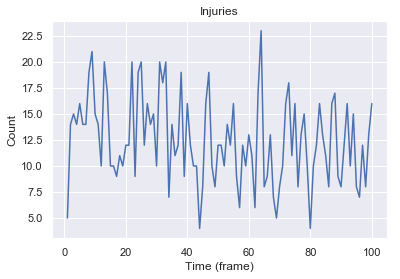

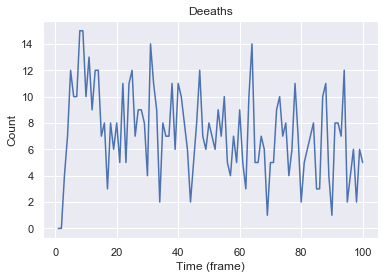

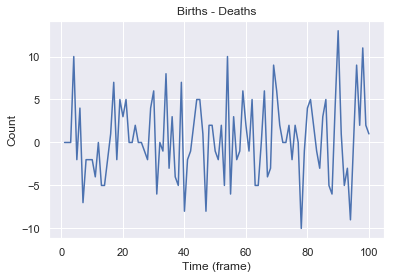

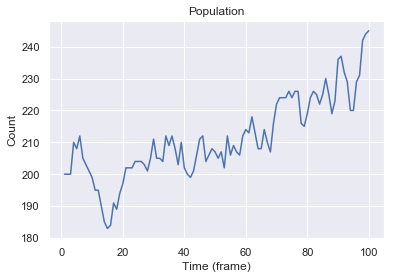

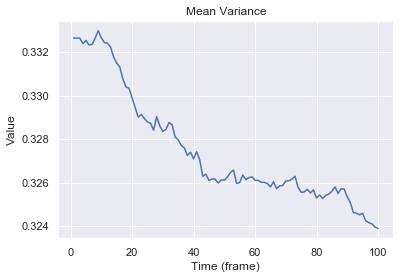

In [11]:
# Growth
plt.plot(t[:,0],t[:,1])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Growth')
plt.grid(True)
plt.show()

# Birth
plt.plot(t[:,0],t[:,2])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Birth')
plt.grid(True)
plt.show()

# Injuries
plt.plot(t[:,0],t[:,3])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Injuries')
plt.grid(True)
plt.show()

# Deaths
plt.plot(t[:,0],t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Deeaths')
plt.grid(True)
plt.show()

# Births-Deaths
plt.plot(t[:,0],t[:,2]-t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Births - Deaths')
plt.grid(True)
plt.show()

# Population
plt.plot(t[:,0],t[:,5])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Population')
plt.grid(True)
plt.show()

# Mean Variance
plt.plot(t[:,0],t[:,6])
plt.xlabel('Time (frame)')
plt.ylabel('Value')
plt.title('Mean Variance')
plt.grid(True)
plt.show()

In [12]:
# Summary
t

array([[  1.        ,   0.        ,   0.        ,   5.        ,
          0.        , 200.        ,   0.3326472 ],
       [  2.        ,   1.        ,   0.        ,  14.        ,
          0.        , 200.        ,   0.3326472 ],
       [  3.        ,   0.        ,   4.        ,  15.        ,
          4.        , 200.        ,   0.33263762],
       [  4.        ,   0.        ,  17.        ,  14.        ,
          7.        , 210.        ,   0.33239317],
       [  5.        ,   6.        ,  10.        ,  16.        ,
         12.        , 208.        ,   0.33253444],
       [  6.        ,   4.        ,  14.        ,  14.        ,
         10.        , 212.        ,   0.33232837],
       [  7.        ,   6.        ,   3.        ,  14.        ,
         10.        , 205.        ,   0.33235712],
       [  8.        ,   4.        ,  13.        ,  19.        ,
         15.        , 203.        ,   0.33264592],
       [  9.        ,   5.        ,  13.        ,  21.        ,
         15.    

In [13]:
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 971\nNumber of edges: 770\nAverage degree:   1.5860'

***
# Continue with previous results
***

In [14]:
c, cw, fn, db = extract_tribe(c, cw, fn, 7, [0])

[6 2 2 2 2 2 3 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2 2 2 2 2 2
 2 2 2 2 5 2 2 2 2 2 2 2 2 2 2 2 3 0 2 2 2 2 1 1 2 2 2 3 2 1 3 2 2 2 2 2 2
 2 2 2 2 1 2 6 5 4 6 2 2 2 2 2 2 2 4 2 0 2 2 2 1 6 2 1 2 2 2 3 5 2 2 2 2 6
 2 6 2 5 2 2 2 5 2 4 2 2 0 0 2 5 2 2 2 2 2 3 2 2 2 4 2 4 1 2 5 4 2 2 0 2 1
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 3 5 2 2 2 2 2 2 2 1 4 4 2 2 2 1 2 0 2 2
 2 2 4 1 2 2 2 0 2 0 2 5 2 2 2 0 2 1 0 1 2 2 2 2 2 2 2 2 2 2 6 2 3 2 2 3 2
 2 6 2 0 2 2 5 2 2 2 2 0 1 2 2 2 5 2 0 2 5 2 0]
[[54, 93, 123, 124, 145, 155, 163, 182, 192, 194, 200, 203, 225, 233, 240, 244]]
[array(['Michael Alvarado', 'Darren Merritt', 'Justin Colon',
       'Matthew Hopkins', 'Sandra Oliver', 'Brendan Arnold',
       'Raymond Todd', 'Christian Smith', 'Jeffery Kennedy',
       'Heather Lin', 'Stephanie Ortiz', 'Joshua Schneider',
       'Sophia Wiggins', 'Justin Huang', 'Ashley Wright', 'Angel Morton'],
      dtype='<U23')]


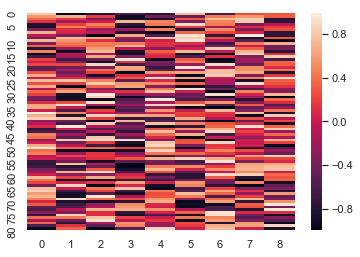

In [15]:
ax = sns.heatmap(cw[0].reshape((sight*sight, 3*3)))

In [ ]:
gr, c, cw, fn, g, t, a = slime(c, cw, fn, frames=100, experimental = True, log = False)

We're going extinct, make babies!  Breeding requirements decreased to 5.
We're going extinct, make babies!  Breeding requirements decreased to 4.
We're going extinct, make babies!  Breeding requirements decreased to 3.
Frame 10 took 0.7 seconds.
Frame 20 took 0.5 seconds.
Frame 30 took 0.6 seconds.
Frame 40 took 0.6 seconds.
Frame 50 took 0.6 seconds.
Frame 60 took 0.6 seconds.
Frame 70 took 0.6 seconds.


In [ ]:
gr

In [ ]:
# Growth
plt.plot(t[:,0],t[:,1])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Growth')
plt.grid(True)
plt.show()

# Birth
plt.plot(t[:,0],t[:,2])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Birth')
plt.grid(True)
plt.show()

# Injuries
plt.plot(t[:,0],t[:,3])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Injuries')
plt.grid(True)
plt.show()

# Deaths
plt.plot(t[:,0],t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Deeaths')
plt.grid(True)
plt.show()

# Births-Deaths
plt.plot(t[:,0],t[:,2]-t[:,4])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Births - Deaths')
plt.grid(True)
plt.show()

# Population
plt.plot(t[:,0],t[:,5])
plt.xlabel('Time (frame)')
plt.ylabel('Count')
plt.title('Population')
plt.grid(True)
plt.show()

# Mean Variance
plt.plot(t[:,0],t[:,6])
plt.xlabel('Time (frame)')
plt.ylabel('Value')
plt.title('Mean Variance')
plt.grid(True)
plt.show()

In [ ]:
# Summary
t

In [ ]:
nx.info(g)

In [ ]:
#import dill
#dill.dump_session('notebook_env.db')

In [ ]:
#import dill
#dill.load_session('notebook_env.db')

In [ ]:
np.add([1,2],[3,4])

In [ ]:
len(AgglomerativeClustering(7).fit(cell_weights).labels_)

In [ ]:
len(cells)

In [ ]:
[]